<a href="https://colab.research.google.com/github/anshikagirdhar/23-CS-065_Anshika-Girdhar_ML-LAB_/blob/main/Experiment%209%20/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as  np
import math
from abc import ABC, abstractmethod
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

In [2]:
data = load_breast_cancer()
X = data.data
y = data.target

In [3]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [4]:
data.target_names

array(['malignant', 'benign'], dtype='<U9')

In [5]:
X.shape,y.shape

((569, 30), (569,))

In [6]:
X[0]

array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
       3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
       8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
       3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
       1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01])

In [7]:
np.unique(y)

array([0, 1])

In [8]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

In [9]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [10]:
def xaiverInit(insize:int,outsize:int,seed:int):
    rng=np.random.default_rng(seed)
    return rng.normal(0,math.sqrt(2/(insize+outsize)),size=(insize,outsize)),np.array([outsize*[1e-03]])

    # return rng.normal(0,1,size=(insize,outsize)),np.random.randn(1,outsize)


def heInit(insize:int,outsize:int,seed:int):
    rng=np.random.default_rng(seed)
    return rng.normal(0,math.sqrt(2/(insize)),size=(insize,outsize)),np.array([outsize*[1e-03]])

In [11]:
initDict={'He':heInit
          ,'Xavier':xaiverInit}

In [12]:
class Layer(ABC):
    @abstractmethod
    def forward(self,x:np.array):
        raise NotImplementedError

    @abstractmethod
    def backward(self,upstreamGrad:np.array):
        raise NotImplementedError

class ParameterisedLayer(Layer):
    @abstractmethod
    def updateParam(self):
        raise NotImplementedError

In [13]:
class Linear(ParameterisedLayer):
    def __init__(self,in_size:int,out_size:int,seed:int,init:str,lr:float):

        assert init in initDict.keys(),f'invalid value of init, supported ones are : {initDict.keys()}'

        self.weights,self.bias=initDict[init](in_size,out_size,seed)
        print(f"weights and bias intialised with shape {self.weights.shape} and {self.bias.shape} respectively")
        self.Wgrad=np.zeros_like(self.weights)
        self.Bgrad=np.zeros_like(self.bias)
        self.lr=lr
        self.x=None

    def forward(self,x:np.ndarray): #batch,in_size
        self.x=x
        return x@self.weights+self.bias

    def backward(self,upstreamGrad:np.ndarray):

        if not isinstance(self.x,np.ndarray):
            raise ValueError("can not call backward before forward")


        self.Wgrad+=self.x.T@upstreamGrad
        self.Bgrad+=np.expand_dims(np.sum(upstreamGrad,axis=0),axis=0)

        self.x=None

        return upstreamGrad@self.weights.T
        # accumulate grad and return grad wrt input

    def updateParam(self):

        # print('norm',np.sum(self.Wgrad**2))
        global norms
        norms.append(np.sum(self.Wgrad**2))
        self.weights-=self.lr*self.Wgrad
        self.bias-=self.lr*self.Bgrad

        #clean the accumulated grad
        self.Wgrad=np.zeros_like(self.Wgrad)
        self.Bgrad=np.zeros_like(self.Bgrad)

In [14]:
class ReLU(Layer):

    def __init__(self):
        self.act=None

    def forward(self,x:np.ndarray):
        self.act=np.maximum(0,x)
        return self.act

    def backward(self,upstreamGrad:np.ndarray):# b,outsize

        if not isinstance(self.act,np.ndarray):
            raise ValueError("can not call backward before forward")

        grad=np.zeros_like(self.act,dtype=np.float32)
        grad[self.act>0]=1

        self.act=None

        return grad*upstreamGrad

class Sigmoid(Layer):

    def __init__(self):
        self.act=None

    def forward(self,x:np.ndarray):
        self.act=1/(1+np.exp(-x))
        return self.act

    def backward(self,upstreamGrad:np.ndarray):#b,outsize

        if not isinstance(self.act,np.ndarray):
            raise ValueError("can not call backward before forward")

        grad=self.act*(1-self.act)

        self.act=None
        return grad*upstreamGrad

In [15]:
class ANN(ParameterisedLayer):
    def __init__(self,num_layers:int,neurons:list,act_fn:str,seed:list,lr:float):
        if not num_layers+1==len(neurons):
            raise ValueError("invalid params passed to ANN")

        act_init_dict={'ReLU':[ReLU,'He']
                       ,'Sigmoid':[Sigmoid,'Xavier']}


        assert act_fn in act_init_dict.keys(), f'invalid value of act_fn supported ones are : {act_init_dict.keys()}'

        assert len(seed)==num_layers

        self.layers=[]

        for i in range(num_layers):
            self.layers.append(Linear(neurons[i],neurons[i+1],seed[i],act_init_dict[act_fn][1],lr))
            if i+1!=num_layers:
                self.layers.append(act_init_dict[act_fn][0]())

    def forward(self,x:np.ndarray):

        for layer in self.layers:
            x=layer.forward(x)

        return x

    def backward(self,upStreamGrad:np.ndarray):

        for layer in self.layers[::-1]:
            upStreamGrad=layer.backward(upStreamGrad)

    def updateParam(self):
        for layer in self.layers[::-2]:
            layer.updateParam()

In [16]:
def BCEWithLogitLoss(logits:np.ndarray,target:np.ndarray):
    # loss=np.maximum(0,logits)-logits*target+np.log1p(np.exp(-np.abs(logits)))/
    target=np.expand_dims(target,axis=-1)
    preds=Sigmoid().forward(logits)
    loss=-(target*np.log(preds)+(1-target)*np.log(1-preds))
    return np.mean(loss)

def MSELoss(logits:np.ndarray,target:np.ndarray):
    target=np.expand_dims(target,axis=-1)

    pred=Sigmoid().forward(logits)

    return np.mean((pred-target)**2)

In [17]:
def BCEGrad(logits:np.ndarray,target:np.ndarray,batch:int):
    target=np.expand_dims(target,axis=-1)
    return (Sigmoid().forward(logits)-target)/batch

def MSEGrad(logits:np.ndarray,target:np.ndarray,batch:int):
    target=np.expand_dims(target,axis=-1)
    return (Sigmoid().forward(logits)-target)*Sigmoid().forward(logits)*(1-Sigmoid().forward(logits))/batch

In [18]:
epochs=100
batch=2**4
num_layers=2
neurons=[30,128,1]
seed=[42,21]
act_fn='ReLU'
lr=1e-02
loss_fn=BCEWithLogitLoss
loss_grad=BCEGrad

In [19]:
model_bce=ANN(num_layers,neurons,act_fn,seed,lr)

train_loss_bce=[]
norms=[]
for epoch in tqdm(range(epochs)):
    running_loss=0
    for i in range(0,X_train.shape[0],batch):
        x=X_train[i:i+batch]
        y=Y_train[i:i+batch]

        logits=model_bce.forward(x)
        loss=loss_fn(logits,y)

        grad=loss_grad(logits,y,batch)
        model_bce.backward(grad)

        model_bce.updateParam()
        # print(np.any(~np.isfinite(logits)))
        # print(loss)
        running_loss+=loss.item()

    train_loss_bce.append(running_loss/math.ceil(X_train.shape[0]/batch))
    print(f'epoch: {epoch:2d} Loss: ',f'{train_loss_bce[-1]:.4f}')


weights and bias intialised with shape (30, 128) and (1, 128) respectively
weights and bias intialised with shape (128, 1) and (1, 1) respectively


  2%|▏         | 2/100 [00:00<00:07, 13.86it/s]

epoch:  0 Loss:  0.4123
epoch:  1 Loss:  0.2580
epoch:  2 Loss:  0.2051
epoch:  3 Loss:  0.1768


  5%|▌         | 5/100 [00:00<00:05, 17.30it/s]

epoch:  4 Loss:  0.1585
epoch:  5 Loss:  0.1452
epoch:  6 Loss:  0.1351
epoch:  7 Loss:  0.1271
epoch:  8 Loss:  0.1206


  9%|▉         | 9/100 [00:00<00:03, 24.36it/s]

epoch:  9 Loss:  0.1151
epoch: 10 Loss:  0.1104


 13%|█▎        | 13/100 [00:00<00:03, 27.53it/s]

epoch: 11 Loss:  0.1064
epoch: 12 Loss:  0.1028
epoch: 13 Loss:  0.0997
epoch: 14 Loss:  0.0969
epoch: 15 Loss:  0.0944


 17%|█▋        | 17/100 [00:00<00:02, 29.70it/s]

epoch: 16 Loss:  0.0922
epoch: 17 Loss:  0.0901


 21%|██        | 21/100 [00:00<00:02, 26.59it/s]

epoch: 18 Loss:  0.0883
epoch: 19 Loss:  0.0865
epoch: 20 Loss:  0.0849
epoch: 21 Loss:  0.0834


 24%|██▍       | 24/100 [00:01<00:03, 22.91it/s]

epoch: 22 Loss:  0.0821
epoch: 23 Loss:  0.0808
epoch: 24 Loss:  0.0795
epoch: 25 Loss:  0.0784
epoch: 26 Loss:  0.0773
epoch: 27 Loss:  0.0763


 30%|███       | 30/100 [00:01<00:02, 29.42it/s]

epoch: 28 Loss:  0.0753
epoch: 29 Loss:  0.0744
epoch: 30 Loss:  0.0736


 36%|███▌      | 36/100 [00:01<00:01, 34.50it/s]

epoch: 31 Loss:  0.0727
epoch: 32 Loss:  0.0719
epoch: 33 Loss:  0.0712
epoch: 34 Loss:  0.0705
epoch: 35 Loss:  0.0698
epoch: 36 Loss:  0.0691


 41%|████      | 41/100 [00:01<00:01, 36.63it/s]

epoch: 37 Loss:  0.0684
epoch: 38 Loss:  0.0678
epoch: 39 Loss:  0.0672
epoch: 40 Loss:  0.0666
epoch: 41 Loss:  0.0661
epoch: 42 Loss:  0.0655
epoch: 43 Loss:  0.0650
epoch: 44 Loss:  0.0645


 45%|████▌     | 45/100 [00:01<00:01, 28.04it/s]

epoch: 45 Loss:  0.0640
epoch: 46 Loss:  0.0635
epoch: 47 Loss:  0.0630


 49%|████▉     | 49/100 [00:01<00:01, 27.05it/s]

epoch: 48 Loss:  0.0626
epoch: 49 Loss:  0.0621
epoch: 50 Loss:  0.0617
epoch: 51 Loss:  0.0613
epoch: 52 Loss:  0.0609


 54%|█████▍    | 54/100 [00:01<00:01, 30.76it/s]

epoch: 53 Loss:  0.0605
epoch: 54 Loss:  0.0601
epoch: 55 Loss:  0.0597


 58%|█████▊    | 58/100 [00:02<00:01, 28.85it/s]

epoch: 56 Loss:  0.0593
epoch: 57 Loss:  0.0589
epoch: 58 Loss:  0.0585
epoch: 59 Loss:  0.0582
epoch: 60 Loss:  0.0578


 68%|██████▊   | 68/100 [00:02<00:00, 32.51it/s]

epoch: 61 Loss:  0.0575
epoch: 62 Loss:  0.0572
epoch: 63 Loss:  0.0568
epoch: 64 Loss:  0.0565
epoch: 65 Loss:  0.0562
epoch: 66 Loss:  0.0559
epoch: 67 Loss:  0.0556
epoch: 68 Loss:  0.0552
epoch: 69 Loss:  0.0549
epoch: 70 Loss:  0.0547
epoch: 71 Loss:  0.0544
epoch: 72 Loss:  0.0541
epoch: 73 Loss:  0.0538
epoch: 74 Loss:  0.0535
epoch: 75 Loss:  0.0532


 82%|████████▏ | 82/100 [00:02<00:00, 45.05it/s]

epoch: 76 Loss:  0.0530
epoch: 77 Loss:  0.0527
epoch: 78 Loss:  0.0524
epoch: 79 Loss:  0.0522
epoch: 80 Loss:  0.0519
epoch: 81 Loss:  0.0517
epoch: 82 Loss:  0.0514
epoch: 83 Loss:  0.0512
epoch: 84 Loss:  0.0509
epoch: 85 Loss:  0.0507
epoch: 86 Loss:  0.0505


 88%|████████▊ | 88/100 [00:02<00:00, 47.43it/s]

epoch: 87 Loss:  0.0502
epoch: 88 Loss:  0.0500
epoch: 89 Loss:  0.0498
epoch: 90 Loss:  0.0495
epoch: 91 Loss:  0.0493
epoch: 92 Loss:  0.0491


 94%|█████████▍| 94/100 [00:02<00:00, 45.76it/s]

epoch: 93 Loss:  0.0489
epoch: 94 Loss:  0.0487
epoch: 95 Loss:  0.0484


100%|██████████| 100/100 [00:03<00:00, 33.30it/s]

epoch: 96 Loss:  0.0482
epoch: 97 Loss:  0.0480
epoch: 98 Loss:  0.0478
epoch: 99 Loss:  0.0476


In [20]:
num_layers=2
neurons=[30,128,1]
seed=[42,21]
loss_fn=MSELoss
loss_grad=MSEGrad

In [21]:
model_mse=ANN(num_layers,neurons,act_fn,seed,lr)

train_loss_mse=[]
norms=[]
for epoch in tqdm(range(epochs)):
    running_loss=0
    for i in range(0,X_train.shape[0],batch):
        x=X_train[i:i+batch]
        y=Y_train[i:i+batch]

        logits=model_mse.forward(x)
        loss=loss_fn(logits,y)

        grad=loss_grad(logits,y,batch)
        model_mse.backward(grad)

        model_mse.updateParam()
        # print(np.any(~np.isfinite(logits)))
        # print(loss)
        running_loss+=loss.item()

    train_loss_mse.append(running_loss/math.ceil(X_train.shape[0]/batch))
    print(f'epoch: {epoch:2d} Loss: ',f'{train_loss_mse[-1]:.4f}')

weights and bias intialised with shape (30, 128) and (1, 128) respectively
weights and bias intialised with shape (128, 1) and (1, 1) respectively


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 Loss:  0.1749
epoch:  1 Loss:  0.1365
epoch:  2 Loss:  0.1153
epoch:  3 Loss:  0.1013


  8%|▊         | 8/100 [00:00<00:01, 71.68it/s]

epoch:  4 Loss:  0.0910
epoch:  5 Loss:  0.0831
epoch:  6 Loss:  0.0768
epoch:  7 Loss:  0.0716
epoch:  8 Loss:  0.0675
epoch:  9 Loss:  0.0640
epoch: 10 Loss:  0.0610
epoch: 11 Loss:  0.0585
epoch: 12 Loss:  0.0563
epoch: 13 Loss:  0.0544
epoch: 14 Loss:  0.0526


 24%|██▍       | 24/100 [00:00<00:01, 60.40it/s]

epoch: 15 Loss:  0.0511
epoch: 16 Loss:  0.0497
epoch: 17 Loss:  0.0484
epoch: 18 Loss:  0.0472
epoch: 19 Loss:  0.0461
epoch: 20 Loss:  0.0450
epoch: 21 Loss:  0.0441
epoch: 22 Loss:  0.0432
epoch: 23 Loss:  0.0423
epoch: 24 Loss:  0.0415
epoch: 25 Loss:  0.0408
epoch: 26 Loss:  0.0401
epoch: 27 Loss:  0.0394
epoch: 28 Loss:  0.0387
epoch: 29 Loss:  0.0381
epoch: 30 Loss:  0.0375


 32%|███▏      | 32/100 [00:00<00:01, 66.63it/s]

epoch: 31 Loss:  0.0370
epoch: 32 Loss:  0.0364
epoch: 33 Loss:  0.0359
epoch: 34 Loss:  0.0354
epoch: 35 Loss:  0.0350
epoch: 36 Loss:  0.0345
epoch: 37 Loss:  0.0341
epoch: 38 Loss:  0.0337


 40%|████      | 40/100 [00:00<00:00, 63.34it/s]

epoch: 39 Loss:  0.0333
epoch: 40 Loss:  0.0329
epoch: 41 Loss:  0.0325
epoch: 42 Loss:  0.0321


 47%|████▋     | 47/100 [00:00<00:00, 57.30it/s]

epoch: 43 Loss:  0.0318
epoch: 44 Loss:  0.0315
epoch: 45 Loss:  0.0311
epoch: 46 Loss:  0.0308
epoch: 47 Loss:  0.0305
epoch: 48 Loss:  0.0302
epoch: 49 Loss:  0.0299
epoch: 50 Loss:  0.0297


 53%|█████▎    | 53/100 [00:00<00:00, 51.77it/s]

epoch: 51 Loss:  0.0294
epoch: 52 Loss:  0.0292
epoch: 53 Loss:  0.0289
epoch: 54 Loss:  0.0287
epoch: 55 Loss:  0.0284
epoch: 56 Loss:  0.0282
epoch: 57 Loss:  0.0280


 59%|█████▉    | 59/100 [00:01<00:00, 45.12it/s]

epoch: 58 Loss:  0.0278


 67%|██████▋   | 67/100 [00:01<00:00, 51.93it/s]

epoch: 59 Loss:  0.0276
epoch: 60 Loss:  0.0274
epoch: 61 Loss:  0.0272
epoch: 62 Loss:  0.0270
epoch: 63 Loss:  0.0268
epoch: 64 Loss:  0.0266
epoch: 65 Loss:  0.0264
epoch: 66 Loss:  0.0263
epoch: 67 Loss:  0.0261
epoch: 68 Loss:  0.0259
epoch: 69 Loss:  0.0258
epoch: 70 Loss:  0.0256


 80%|████████  | 80/100 [00:01<00:00, 49.97it/s]

epoch: 71 Loss:  0.0255
epoch: 72 Loss:  0.0253
epoch: 73 Loss:  0.0252
epoch: 74 Loss:  0.0250
epoch: 75 Loss:  0.0249
epoch: 76 Loss:  0.0248
epoch: 77 Loss:  0.0246
epoch: 78 Loss:  0.0245
epoch: 79 Loss:  0.0244
epoch: 80 Loss:  0.0242


 86%|████████▌ | 86/100 [00:01<00:00, 48.51it/s]

epoch: 81 Loss:  0.0241
epoch: 82 Loss:  0.0240
epoch: 83 Loss:  0.0239
epoch: 84 Loss:  0.0238
epoch: 85 Loss:  0.0237
epoch: 86 Loss:  0.0236
epoch: 87 Loss:  0.0234
epoch: 88 Loss:  0.0233
epoch: 89 Loss:  0.0232
epoch: 90 Loss:  0.0231
epoch: 91 Loss:  0.0230


 93%|█████████▎| 93/100 [00:01<00:00, 49.60it/s]

epoch: 92 Loss:  0.0229


100%|██████████| 100/100 [00:01<00:00, 51.05it/s]

epoch: 93 Loss:  0.0228
epoch: 94 Loss:  0.0227
epoch: 95 Loss:  0.0226
epoch: 96 Loss:  0.0226
epoch: 97 Loss:  0.0225
epoch: 98 Loss:  0.0224
epoch: 99 Loss:  0.0223


In [22]:
num_layers=3
neurons=[30,128,128,1]
seed=[42,21,31]
loss_fn=BCEWithLogitLoss
loss_grad=BCEGrad

In [23]:
model_deeper=ANN(num_layers,neurons,act_fn,seed,lr)

train_loss_deeper=[]
norms=[]
for epoch in tqdm(range(epochs)):
    running_loss=0
    for i in range(0,X_train.shape[0],batch):
        x=X_train[i:i+batch]
        y=Y_train[i:i+batch]

        logits=model_deeper.forward(x)
        loss=loss_fn(logits,y)

        grad=loss_grad(logits,y,batch)
        model_deeper.backward(grad)

        model_deeper.updateParam()
        # print(np.any(~np.isfinite(logits)))
        # print(loss)
        running_loss+=loss.item()

    train_loss_deeper.append(running_loss/math.ceil(X_train.shape[0]/batch))
    print(f'epoch: {epoch:2d} Loss: ',f'{train_loss_deeper[-1]:.4f}')

weights and bias intialised with shape (30, 128) and (1, 128) respectively
weights and bias intialised with shape (128, 128) and (1, 128) respectively
weights and bias intialised with shape (128, 1) and (1, 1) respectively


  2%|▏         | 2/100 [00:00<00:05, 18.18it/s]

epoch:  0 Loss:  0.4492
epoch:  1 Loss:  0.2547
epoch:  2 Loss:  0.2022


  4%|▍         | 4/100 [00:00<00:05, 17.31it/s]

epoch:  3 Loss:  0.1735
epoch:  4 Loss:  0.1541


  6%|▌         | 6/100 [00:00<00:08, 11.54it/s]

epoch:  5 Loss:  0.1397
epoch:  6 Loss:  0.1285


  8%|▊         | 8/100 [00:00<00:07, 11.70it/s]

epoch:  7 Loss:  0.1194


 10%|█         | 10/100 [00:00<00:07, 11.31it/s]

epoch:  8 Loss:  0.1119
epoch:  9 Loss:  0.1056
epoch: 10 Loss:  0.1002


 12%|█▏        | 12/100 [00:01<00:07, 11.07it/s]

epoch: 11 Loss:  0.0955
epoch: 12 Loss:  0.0914


 14%|█▍        | 14/100 [00:01<00:07, 11.31it/s]

epoch: 13 Loss:  0.0877
epoch: 14 Loss:  0.0844


 17%|█▋        | 17/100 [00:01<00:05, 14.45it/s]

epoch: 15 Loss:  0.0814
epoch: 16 Loss:  0.0786
epoch: 17 Loss:  0.0761


 19%|█▉        | 19/100 [00:01<00:05, 15.51it/s]

epoch: 18 Loss:  0.0738
epoch: 19 Loss:  0.0717
epoch: 20 Loss:  0.0697


 24%|██▍       | 24/100 [00:01<00:03, 22.83it/s]

epoch: 21 Loss:  0.0679
epoch: 22 Loss:  0.0662
epoch: 23 Loss:  0.0646
epoch: 24 Loss:  0.0632
epoch: 25 Loss:  0.0618


 27%|██▋       | 27/100 [00:01<00:03, 24.20it/s]

epoch: 26 Loss:  0.0605
epoch: 27 Loss:  0.0593


 30%|███       | 30/100 [00:01<00:02, 23.39it/s]

epoch: 28 Loss:  0.0581
epoch: 29 Loss:  0.0570
epoch: 30 Loss:  0.0560


 36%|███▌      | 36/100 [00:02<00:02, 22.68it/s]

epoch: 31 Loss:  0.0550
epoch: 32 Loss:  0.0540
epoch: 33 Loss:  0.0531
epoch: 34 Loss:  0.0522
epoch: 35 Loss:  0.0514
epoch: 36 Loss:  0.0505
epoch: 37 Loss:  0.0497


 39%|███▉      | 39/100 [00:02<00:02, 22.37it/s]

epoch: 38 Loss:  0.0490
epoch: 39 Loss:  0.0482


 42%|████▏     | 42/100 [00:02<00:02, 21.83it/s]

epoch: 40 Loss:  0.0475
epoch: 41 Loss:  0.0468
epoch: 42 Loss:  0.0461
epoch: 43 Loss:  0.0455


 45%|████▌     | 45/100 [00:02<00:02, 19.02it/s]

epoch: 44 Loss:  0.0448
epoch: 45 Loss:  0.0442
epoch: 46 Loss:  0.0436
epoch: 47 Loss:  0.0430
epoch: 48 Loss:  0.0424


 50%|█████     | 50/100 [00:02<00:02, 23.98it/s]

epoch: 49 Loss:  0.0418
epoch: 50 Loss:  0.0413


 53%|█████▎    | 53/100 [00:02<00:01, 23.85it/s]

epoch: 51 Loss:  0.0407
epoch: 52 Loss:  0.0402
epoch: 53 Loss:  0.0397
epoch: 54 Loss:  0.0392


 56%|█████▌    | 56/100 [00:02<00:01, 25.27it/s]

epoch: 55 Loss:  0.0387
epoch: 56 Loss:  0.0382


 59%|█████▉    | 59/100 [00:03<00:01, 25.19it/s]

epoch: 57 Loss:  0.0377
epoch: 58 Loss:  0.0373
epoch: 59 Loss:  0.0368
epoch: 60 Loss:  0.0364


 62%|██████▏   | 62/100 [00:03<00:01, 25.58it/s]

epoch: 61 Loss:  0.0359
epoch: 62 Loss:  0.0355


 65%|██████▌   | 65/100 [00:03<00:01, 26.24it/s]

epoch: 63 Loss:  0.0351
epoch: 64 Loss:  0.0347
epoch: 65 Loss:  0.0342
epoch: 66 Loss:  0.0338
epoch: 67 Loss:  0.0334


 70%|███████   | 70/100 [00:03<00:01, 28.26it/s]

epoch: 68 Loss:  0.0330
epoch: 69 Loss:  0.0327


 74%|███████▍  | 74/100 [00:03<00:00, 30.62it/s]

epoch: 70 Loss:  0.0323
epoch: 71 Loss:  0.0319
epoch: 72 Loss:  0.0315
epoch: 73 Loss:  0.0312
epoch: 74 Loss:  0.0308


 79%|███████▉  | 79/100 [00:03<00:00, 34.34it/s]

epoch: 75 Loss:  0.0305
epoch: 76 Loss:  0.0301
epoch: 77 Loss:  0.0298
epoch: 78 Loss:  0.0294
epoch: 79 Loss:  0.0291


 83%|████████▎ | 83/100 [00:03<00:00, 34.97it/s]

epoch: 80 Loss:  0.0288
epoch: 81 Loss:  0.0284
epoch: 82 Loss:  0.0281


 88%|████████▊ | 88/100 [00:03<00:00, 37.69it/s]

epoch: 83 Loss:  0.0278
epoch: 84 Loss:  0.0275
epoch: 85 Loss:  0.0272
epoch: 86 Loss:  0.0269
epoch: 87 Loss:  0.0266
epoch: 88 Loss:  0.0263
epoch: 89 Loss:  0.0260


 92%|█████████▏| 92/100 [00:03<00:00, 36.94it/s]

epoch: 90 Loss:  0.0257
epoch: 91 Loss:  0.0254


 96%|█████████▌| 96/100 [00:04<00:00, 35.18it/s]

epoch: 92 Loss:  0.0252
epoch: 93 Loss:  0.0249
epoch: 94 Loss:  0.0246
epoch: 95 Loss:  0.0244
epoch: 96 Loss:  0.0241
epoch: 97 Loss:  0.0238


100%|██████████| 100/100 [00:04<00:00, 23.38it/s]

epoch: 98 Loss:  0.0236
epoch: 99 Loss:  0.0233


In [24]:
num_layers=3
neurons=[30,128,128,1]
seed=[42,21,31]
loss_fn=MSELoss
loss_grad=MSEGrad

In [25]:
model_deeper_mse=ANN(num_layers,neurons,act_fn,seed,lr)

train_loss_deeper_mse=[]
norms=[]
for epoch in tqdm(range(epochs)):
    running_loss=0
    for i in range(0,X_train.shape[0],batch):
        x=X_train[i:i+batch]
        y=Y_train[i:i+batch]

        logits=model_deeper_mse.forward(x)
        loss=loss_fn(logits,y)

        grad=loss_grad(logits,y,batch)
        model_deeper_mse.backward(grad)

        model_deeper_mse.updateParam()
        # print(np.any(~np.isfinite(logits)))
        # print(loss)
        running_loss+=loss.item()

    train_loss_deeper_mse.append(running_loss/math.ceil(X_train.shape[0]/batch))
    print(f'epoch: {epoch:2d} Loss: ',f'{train_loss_deeper_mse[-1]:.4f}')

weights and bias intialised with shape (30, 128) and (1, 128) respectively
weights and bias intialised with shape (128, 128) and (1, 128) respectively
weights and bias intialised with shape (128, 1) and (1, 1) respectively


  0%|          | 0/100 [00:00<?, ?it/s]

epoch:  0 Loss:  0.2210


  2%|▏         | 2/100 [00:00<00:06, 15.08it/s]

epoch:  1 Loss:  0.1490
epoch:  2 Loss:  0.1158


  6%|▌         | 6/100 [00:00<00:03, 26.82it/s]

epoch:  3 Loss:  0.0973
epoch:  4 Loss:  0.0857
epoch:  5 Loss:  0.0779
epoch:  6 Loss:  0.0721
epoch:  7 Loss:  0.0677
epoch:  8 Loss:  0.0641


 10%|█         | 10/100 [00:00<00:02, 30.56it/s]

epoch:  9 Loss:  0.0612
epoch: 10 Loss:  0.0586


 15%|█▌        | 15/100 [00:00<00:02, 34.61it/s]

epoch: 11 Loss:  0.0564
epoch: 12 Loss:  0.0545
epoch: 13 Loss:  0.0528
epoch: 14 Loss:  0.0512
epoch: 15 Loss:  0.0498
epoch: 16 Loss:  0.0485


 19%|█▉        | 19/100 [00:00<00:02, 34.02it/s]

epoch: 17 Loss:  0.0472
epoch: 18 Loss:  0.0461


 23%|██▎       | 23/100 [00:00<00:02, 35.46it/s]

epoch: 19 Loss:  0.0450
epoch: 20 Loss:  0.0440
epoch: 21 Loss:  0.0431
epoch: 22 Loss:  0.0422
epoch: 23 Loss:  0.0414
epoch: 24 Loss:  0.0406
epoch: 25 Loss:  0.0398
epoch: 26 Loss:  0.0391


 31%|███       | 31/100 [00:00<00:01, 35.58it/s]

epoch: 27 Loss:  0.0385
epoch: 28 Loss:  0.0378
epoch: 29 Loss:  0.0372
epoch: 30 Loss:  0.0366
epoch: 31 Loss:  0.0361
epoch: 32 Loss:  0.0355


 36%|███▌      | 36/100 [00:01<00:01, 37.63it/s]

epoch: 33 Loss:  0.0350
epoch: 34 Loss:  0.0345
epoch: 35 Loss:  0.0340
epoch: 36 Loss:  0.0336
epoch: 37 Loss:  0.0331
epoch: 38 Loss:  0.0327
epoch: 39 Loss:  0.0323


 41%|████      | 41/100 [00:01<00:01, 38.79it/s]

epoch: 40 Loss:  0.0319
epoch: 41 Loss:  0.0315
epoch: 42 Loss:  0.0311
epoch: 43 Loss:  0.0307
epoch: 44 Loss:  0.0304


 46%|████▌     | 46/100 [00:01<00:01, 40.04it/s]

epoch: 45 Loss:  0.0300
epoch: 46 Loss:  0.0297
epoch: 47 Loss:  0.0294
epoch: 48 Loss:  0.0291


 51%|█████     | 51/100 [00:01<00:01, 39.47it/s]

epoch: 49 Loss:  0.0288
epoch: 50 Loss:  0.0285
epoch: 51 Loss:  0.0282


 55%|█████▌    | 55/100 [00:01<00:01, 36.74it/s]

epoch: 52 Loss:  0.0279
epoch: 53 Loss:  0.0276
epoch: 54 Loss:  0.0274
epoch: 55 Loss:  0.0271


 59%|█████▉    | 59/100 [00:01<00:01, 36.06it/s]

epoch: 56 Loss:  0.0268
epoch: 57 Loss:  0.0266
epoch: 58 Loss:  0.0263
epoch: 59 Loss:  0.0261
epoch: 60 Loss:  0.0259
epoch: 61 Loss:  0.0256


 63%|██████▎   | 63/100 [00:01<00:01, 31.91it/s]

epoch: 62 Loss:  0.0254
epoch: 63 Loss:  0.0252
epoch: 64 Loss:  0.0250


 67%|██████▋   | 67/100 [00:01<00:01, 30.37it/s]

epoch: 65 Loss:  0.0248
epoch: 66 Loss:  0.0246
epoch: 67 Loss:  0.0244
epoch: 68 Loss:  0.0242
epoch: 69 Loss:  0.0240


 71%|███████   | 71/100 [00:02<00:01, 27.42it/s]

epoch: 70 Loss:  0.0238
epoch: 71 Loss:  0.0236


 74%|███████▍  | 74/100 [00:02<00:01, 25.86it/s]

epoch: 72 Loss:  0.0234
epoch: 73 Loss:  0.0232
epoch: 74 Loss:  0.0231
epoch: 75 Loss:  0.0229
epoch: 76 Loss:  0.0227


 81%|████████  | 81/100 [00:02<00:00, 35.48it/s]

epoch: 77 Loss:  0.0226
epoch: 78 Loss:  0.0224
epoch: 79 Loss:  0.0222
epoch: 80 Loss:  0.0221
epoch: 81 Loss:  0.0219
epoch: 82 Loss:  0.0218
epoch: 83 Loss:  0.0217
epoch: 84 Loss:  0.0215
epoch: 85 Loss:  0.0214


 89%|████████▉ | 89/100 [00:02<00:00, 45.12it/s]

epoch: 86 Loss:  0.0212
epoch: 87 Loss:  0.0211
epoch: 88 Loss:  0.0210
epoch: 89 Loss:  0.0208
epoch: 90 Loss:  0.0207
epoch: 91 Loss:  0.0206
epoch: 92 Loss:  0.0205


100%|██████████| 100/100 [00:02<00:00, 37.67it/s]

epoch: 93 Loss:  0.0204
epoch: 94 Loss:  0.0202
epoch: 95 Loss:  0.0201
epoch: 96 Loss:  0.0200
epoch: 97 Loss:  0.0199
epoch: 98 Loss:  0.0198
epoch: 99 Loss:  0.0197


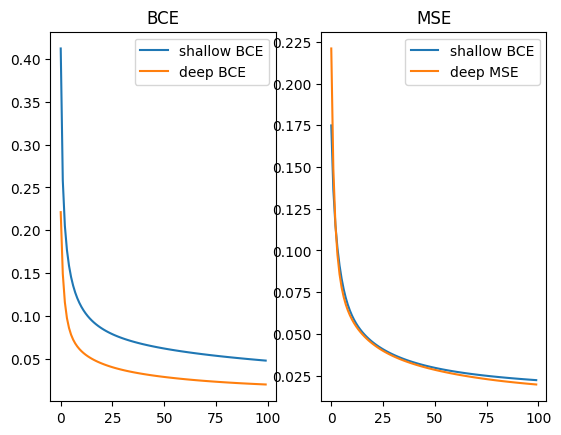

In [26]:
plt.subplot(1,2,1)
plt.plot(train_loss_bce,label='shallow BCE')
plt.plot(train_loss_deeper_mse,label='deep BCE')
plt.title("BCE")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_loss_mse,label='shallow BCE')
plt.plot(train_loss_deeper_mse,label='deep MSE')
plt.title("MSE")
plt.legend()
plt.show()

In [27]:
thres=0.5

pred_shallow_bce=(model_bce.forward(X_test)>=thres).astype(np.uint32)
pred_shallow_mse=(model_mse.forward(X_test)>=thres).astype(np.uint32)

pred_deep_bce=(model_deeper.forward(X_test)>=thres).astype(np.uint32)
pred_deep_mse=(model_deeper_mse.forward(X_test)>=thres).astype(np.uint32)

In [28]:
for preds in [pred_shallow_bce,pred_shallow_mse,pred_deep_bce,pred_deep_mse]:
    print(classification_report(Y_test,preds))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        64
           1       0.98      0.96      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        64
           1       0.97      0.91      0.94       107

    accuracy                           0.92       171
   macro avg       0.91      0.93      0.92       171
weighted avg       0.93      0.92      0.92       171

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        64
           1       0.98      0.96      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171

              preci

In [29]:
net=MLPClassifier(hidden_layer_sizes=(128,),solver='sgd',random_state=1,batch_size=batch,alpha=lr)
net.fit(X_train,Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=16, hidden_layer_sizes=(128,),
              random_state=1, solver='sgd')

In [30]:

print(classification_report(Y_test,net.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        64
           1       0.99      0.97      0.98       107

    accuracy                           0.98       171
   macro avg       0.97      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



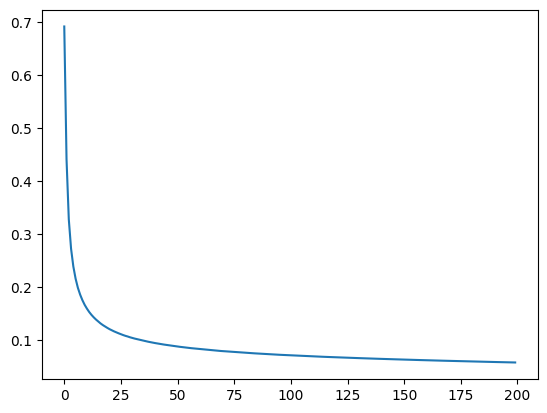

In [33]:
plt.plot(net.loss_curve_)
plt.show()